Представьте, что вы работаете аналитиком в очень крупной компании по доставке пиццы над приложением для курьеров.

У вас есть несколько ресторанов в разных частях города и целый штат курьеров. Но есть одна проблема — к вечеру скорость доставки падает из-за того, что курьеры уходят домой после рабочего дня, а количество заказов лишь растет. Это приводит к тому, что в момент пересмены наша доставка очень сильно проседает в эффективности. 

Наши data scientist-ы придумали новый алгоритм, который позволяет курьерам запланировать свои последние заказы перед окончанием рабочего дня так, чтобы их маршрут доставки совпадал с маршрутом до дома. То есть, чтобы курьеры доставляли последние свои заказы за день как бы "по пути" домой. 

Вы вместе с командой решили раскатить A/B тест на две равные группы курьеров. Часть курьеров использует старый алгоритм без опции "по пути", другие видят в своем приложении эту опцию и могут ее выбрать. Ваша задача – проанализировать данные эксперимента и помочь бизнесу принять решение о раскатке новой фичи на всех курьеров.

## Описание данных
- order_id - id заказа
- delivery_time - время доставки в минутах
- district - район доставки
- experiment_group - экспериментальная группа

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns

In [5]:
df = pd.read_csv(r"E:\Downloads\experiment_lesson_4.csv")

In [6]:
df.head()

,order_id,delivery_time,district,experiment_group
0,3159,44.0,Purlieus,control
1,10426,51.0,Purlieus,control
2,9155,46.0,Purlieus,control
3,10699,34.0,Purlieus,control
4,10061,43.0,Purlieus,control


In [7]:
df.info() # проверка на целостность данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20196 entries, 0 to 20195
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   order_id          20196 non-null  int64  
 1   delivery_time     20196 non-null  float64
 2   district          20196 non-null  object 
 3   experiment_group  20196 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 631.2+ KB


In [7]:
df.duplicated().sum() # проверка на дубликаты

0

### Статистические гипотезы
- H0 - разница среднего времени доставки между контрольной и тестовой группы случайна и на самом деле ее нет
- H1 - разница между средним временем доставки в тестовой и контрольной группе есть, и она не случайна

### Исследуемые гипотезы
- H0 - новый алгоритм не влияет на скорость доставки
- H1 - новый алгоритм влияет на скорость доставки

### 1. Рассмотрим распределение времени в контрольной и тестовой группах в срезе районов

district
Central     AxesSubplot(0.125,0.125;0.775x0.755)
Purlieus    AxesSubplot(0.125,0.125;0.775x0.755)
Suburb      AxesSubplot(0.125,0.125;0.775x0.755)
Name: delivery_time, dtype: object

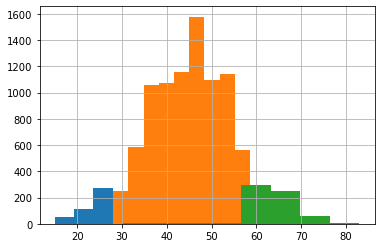

In [8]:
df.query('experiment_group == "control"').groupby('district').delivery_time.hist()

district
Central     AxesSubplot(0.125,0.125;0.775x0.755)
Purlieus    AxesSubplot(0.125,0.125;0.775x0.755)
Suburb      AxesSubplot(0.125,0.125;0.775x0.755)
Name: delivery_time, dtype: object

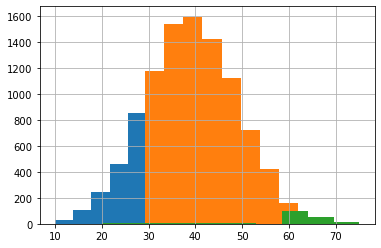

In [9]:
df.query('experiment_group == "test"').groupby('district').delivery_time.hist()

### Измерим разницу выборок

In [11]:
df.groupby('experiment_group').agg({'order_id':'count'}).reset_index()

,experiment_group,order_id
0,control,10092
1,test,10104


### проверим выборки на нормальность распределения

<AxesSubplot:xlabel='delivery_time', ylabel='Count'>

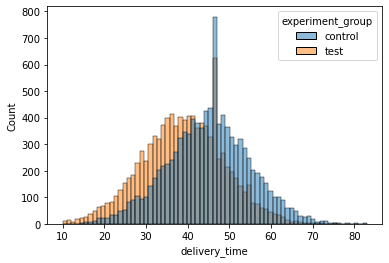

In [12]:
sns.histplot(data = df, x='delivery_time', hue='experiment_group') # визуально нормальные, по 1 выбросу в каждой

**при таких больших выборках можно обойтись только визуальной проверкой на нормальность. Также можно проверить выборки при помощи следующих тестов::**
- при помощи теста Шапиро-Уилка (подходит больше для маленьких выборок)
- при помощи теста Агостино-Пирсона

In [3]:
from scipy.stats import shapiro

In [13]:
df.head()

,order_id,delivery_time,district,experiment_group
0,3159,44.0,Purlieus,control
1,10426,51.0,Purlieus,control
2,9155,46.0,Purlieus,control
3,10699,34.0,Purlieus,control
4,10061,43.0,Purlieus,control


In [23]:
control = df.query('experiment_group == "control"').delivery_time # формирование масива контрольной группы
test    = df.query('experiment_group == "test"').delivery_time # формирование массива тестовой группы

In [17]:
shapiro(test)

ShapiroResult(statistic=0.9986444711685181, pvalue=1.3960703881821246e-07)

In [18]:
shapiro(control)

ShapiroResult(statistic=0.9987275004386902, pvalue=3.4373641710772063e-07)

### В обоих случаях p-value намного меньше порога, что говорит о ненормальности распределния. Проверим более подходящим тестом

In [20]:
from scipy.stats import normaltest

In [21]:
normaltest(control) # распределение нормальное

NormaltestResult(statistic=0.25349755437872584, pvalue=0.8809549607809654)

In [24]:
normaltest(test) # распределение ненормальное

NormaltestResult(statistic=7.024157092641915, pvalue=0.02983483685333173)

In [25]:
test.std() # стандартное отклонение тестовой группы

9.883308351129031

In [26]:
test.mean() # среднее время доставки тестовой группы

39.04681314330958

In [27]:
control.std() # стандартное отклонение контрольной группы

9.990016960247171

In [28]:
control.mean() # среднее время доставки контрольной группы

45.065101070154576

### тестовое распределение получилось ненормальным, однако визуально это не так. Необходимо отметить, что на большой выборке этими тестами можно пренебречь. 
### Дисперсии обеих выборок примерно равны (исходя из СКО), что говорит о гомогенности дисперсий (одно из условий для проведения t-теста)

### визуально среднее время доставки до и после введения алгоритма отличается. Необходимо проврить, случайно ли это различие 

In [30]:
from scipy.stats import ttest_ind

In [32]:
ttest_ind(test, control)

Ttest_indResult(statistic=-43.03582663183714, pvalue=0.0)

p-value <= 0.05, что дает право отклонить нулевую гипотезу о том, что различия средних времени доставки случайны

### Измерим % изменение времени

In [33]:
(1 - test.mean() / control.mean()) * 100

13.354653121660808

### Выводы: можно раскатывать новый алгоритм на всех, так как среднее время доставки статистически значимо изменилось. Среднее время доставки в тесте меньше, чем в контроле на 13.15%.